# LineIntegralConvolution.jl

Line Integral Convolution (LIC) visualization tool for vector fields

## Example

In [1]:
using Plots

In [2]:
using LineIntegralConvolution

[ Info: Precompiling LineIntegralConvolution [954431ae-a746-4b0b-bf75-a8381ca95b21]


In [3]:
pt_per_meter = 25  # resolution, number of pixels per meter
x_min = -10.
x_max = 10.
y_min = 2.
y_max = 13.
n_charges = 10  # number of charges to simulate
charge_value = 1e-6  # electric charge value (C)
distribution = "circle"  # "circle", "random"
SEED = 1
field_result = load_2d_electrostatic_example(
    x_min, x_max, y_min, y_max, pt_per_meter,
    n_charges=n_charges, distribution=distribution,
    seed=SEED,
    charge_value=charge_value
)

(x = -10.0:0.04:10.0, y = 2.0:0.04:13.0, z = [29.27206411183231 29.30232929774155 … 29.302472313699035 29.27220684069041; 29.293475815595773 29.323902591182648 … 29.32404637347457 29.293619303783892; … ; 29.293632796334066 29.32406076039883 … 29.324204548327202 29.29377629010686; 29.272221277780414 29.302487646071242 … 29.302630667636006 29.272364012194796], f = [-510.48496690043817 -512.9677903396936 … 512.9795342741635 510.49666424739235; -514.4335170741497 -516.9579746371874 … 516.9699162281973 514.4454098597487; … ; -514.4626067569924 -516.9873721432549 … 516.9993151956951 514.4745009875242; -510.51381184345473 -512.9969383550283 … 513.0086837282745 510.52551061313704;;; -335.19571729445113 -338.6268702122478 … -338.64317029772326 -335.2118133058856; -335.4268598054753 -338.8774506566746 … -338.89384376045894 -335.44304634052816; … ; 335.4284898591604 338.8792230800182 … 338.89561686515106 335.4446770571859; 335.1974770717476 338.6287727987696 … 338.64507356759304 335.2135737483034

4.854059995950129 %
9.465850906881888 %
54.36373629552489 %
57.59133906100842 %
58.794006190517514 %
58.95238508490266 %
64.50504787526397 %
65.91744048135612 %
76.70166912551709 %
77.5586508143134 %
83.61320836587694 %
88.64155746478059 %


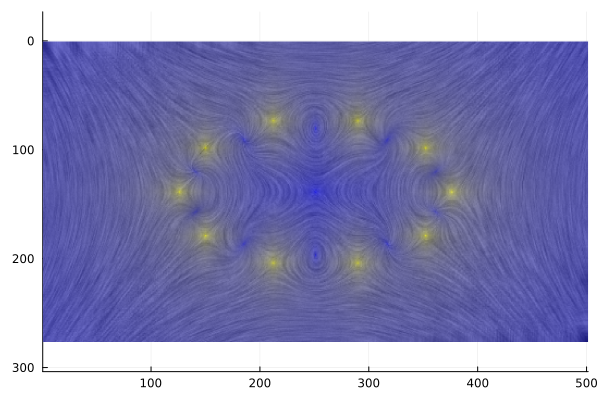

In [4]:
lic(field_result.f)

heatmap(
    field_result.x, 
    field_result.y,
    img.final_img,
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:grays
)
title!("LIC (LPF)")
scatter!(
    [field_result.cx], 
    [field_result.cy],
    zcolor=field_result.cq,
    legend=false,
    markerstrokewidth=0, 
    marker=:circle, 
    markersize=5.0, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:rainbow,
    colorbar=false
)
title!("Electric Charges - N=$n_charges (SEED=$SEED)")
xlabel!("x (m)")
ylabel!("y (m)")


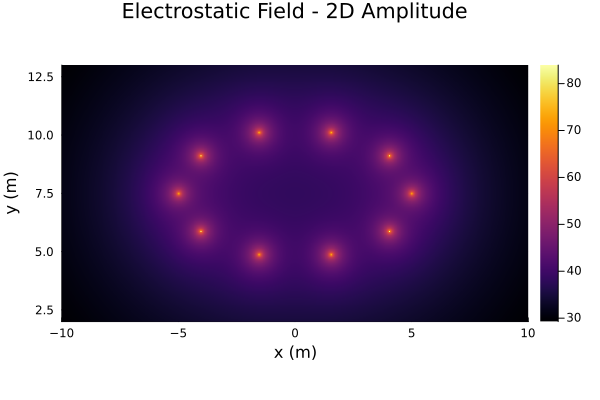

In [9]:
heatmap(
    field_result.x,
    field_result.y,
    field_result.z, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max)
)
title!("Electrostatic Field - 2D Amplitude - N=$n_charges (SEED=$SEED)")
xlabel!("x (m)")
ylabel!("y (m)")
# TODO colorbar label is missing

scatter!(
    [field_result.cx], 
    [field_result.cy],
    zcolor=field_result.cq,
    legend=false, 
    markerstrokewidth=0, 
    marker=:circle, 
    markersize=5.0, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:rainbow
)
# title!("Electric Charges - N=$n_charges (SEED=$SEED)")
# xlabel!("x (m)")
# ylabel!("y (m)")

In [13]:
savefig("electric_charges.pdf")  # export to PDF vectorial image
savefig("electric_charges.png")  # export to PNG

"/Users/davide/electric_charges.png"